### Importing Required Libraries

In [1]:
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV

import lightgbm
import pandas as pd
import os
import seaborn as sns

os.chdir('../data')

### Importing the dataset

In [2]:
try:
    train = pd.read_csv(r'train.csv')
    test = pd.read_csv(r'test.csv')
except:
    print('Error reading training/testing file.')

In [3]:
print(f'Our training dataset has {train.shape[0]} rows and {train.shape[1]} columns. \
    \nTesting dataset has {test.shape[0]} rows and {train.shape[1]} columns.')

Our training dataset has 891 rows and 12 columns.     
Testing dataset has 418 rows and 12 columns.


In [4]:
# Taking a peek at the dataset
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Notes**

Taking a first look at the dataset, we see categorical features like Pclass, Sex, Embarked. We will create a pipeline to try out different ways in which we can treat these: 
    - Ordinal encoding (with trees, since they don't rely on a distance based approach. This is important because, ordinal encoding implies some sort of ranking based on numerical values. We want models that won't be affected by this)
    - One hot encoding (with this we can rely on both trees or distance based methods like ridge)

### Exploratory Data Analysis

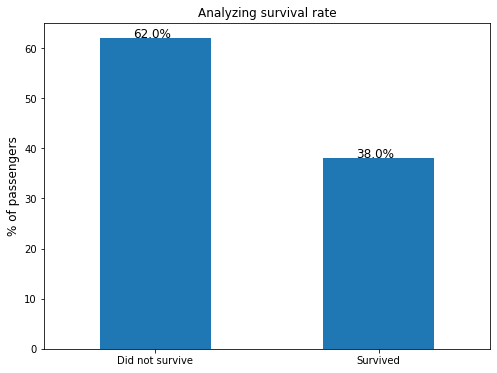

In [7]:
survival_rate = round(train.Survived.value_counts(normalize=True) * 100, 0)
survival_rate.set_axis(['Did not survive', 'Survived'], inplace=True)

plt.figure(figsize=(8, 6))
survival_rate.plot(kind='bar', rot=0)

# creating a reusable font dict
font = {'weight': 'normal',
        'size': 12
        }
# adding text to the plot
for index in range(survival_rate.shape[0]):
    plt.text(index - 0.1, survival_rate.iloc[index] + 0.1, str(survival_rate.iloc[index]) + '%', fontdict=font)

# Adding title and labels to the plot
plt.title('Analyzing survival rate', fontdict=font)
plt.ylabel('% of passengers', fontdict=font)
plt.show()

**Looking at the dataset above, there's an imbalance that we will have to handle**

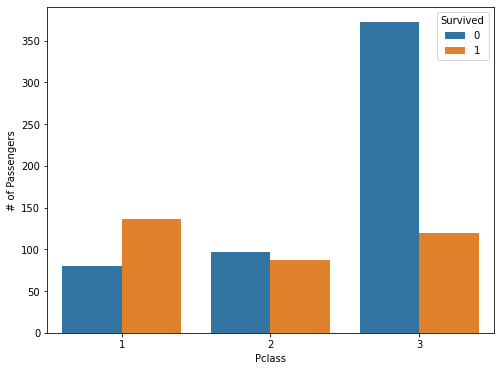

In [8]:
survival_by_class = train.groupby(['Pclass', 'Survived']).PassengerId.count().reset_index().rename(columns={'PassengerId': '# of Passengers'})
plt.figure(figsize=(8, 6))
sns.barplot(x='Pclass', y='# of Passengers', hue='Survived', data=survival_by_class)
plt.show()

**pclass serves as a proxy for socio-economic status. 3rd class was present in lower levels and has the worst survival rate of all the classes**

In [9]:
survival_by_embarked = train.groupby(['Embarked']).PassengerId.count().reset_index().rename(columns={'PassengerId': '# of Passengers'})
survival_by_embarked

,Embarked,# of Passengers
0,C,168
1,Q,77
2,S,644


**Port of embarkation indicates the port from where the passenger boarded the Titanic. Intuitively, I would not expect this to contribute strongly to the model.**

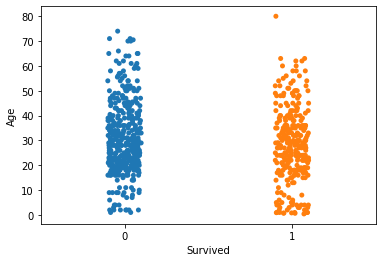

In [10]:
sns.stripplot(data=train, x='Survived', y='Age')
plt.show()

In [11]:
train.groupby(['SibSp', 'Survived']).PassengerId.count().reset_index()

,SibSp,Survived,PassengerId
0,0,0,398
1,0,1,210
2,1,0,97
3,1,1,112
4,2,0,15
5,2,1,13
6,3,0,12
7,3,1,4
8,4,0,15
9,4,1,3


**SibSp is an indicator of the number of siblings of spouses of a particular passenger**

In [12]:
train.Cabin.value_counts(dropna=False, normalize=True)

NaN            0.771044
C23 C25 C27    0.004489
G6             0.004489
B96 B98        0.004489
C22 C26        0.003367
                 ...   
E34            0.001122
C7             0.001122
C54            0.001122
E36            0.001122
C148           0.001122
Name: Cabin, Length: 148, dtype: float64

**The column cabin has a lot of null values, as seen above. There could be a reason for this value missing i.e. only 1st class passengers have a cabin, the rest don't. So, we will impute a random value for all rows without a cabin value.**

In [13]:
train.isna().sum()[train.isna().sum()!=0]

Age         177
Cabin       687
Embarked      2
dtype: int64

## Data Engineering and Model Building

In [14]:
columns_to_remove = ['PassengerId', 'Name', 'Ticket', 'Fare']

In [28]:
# Creating a custom column remover
class CustomColumnRemover(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_remove=None):
        try:
            self.columns_to_remove = columns_to_remove
        except:
            pass
    
    def fit(self, X, y=None):
        self._remaining_columns = [column for column in X.columns if column not in self.columns_to_remove]
        return self

    def transform(self, X):
        _X = X.copy(deep=True)
        return _X.loc[:, self._remaining_columns]

In [16]:
# Creating a custom column remover
class CabinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        _X = X.copy(deep=True)
        try:
            _X.loc[:, 'Cabin'] = _X.loc[:, 'Cabin'].str[0]
        except:
            pass
        finally:
            _X.loc[:, 'Cabin'].fillna('Unknown', inplace=True)
        return _X

In [37]:
y_columns = 'Survived'
X_columns = [column for column in train.columns if column != y_columns]

X = train.loc[:, X_columns]
y = train.loc[:, y_columns]

X_test = test.loc[:, X_columns]

remaining_columns = [column for column in X.columns if column not in columns_to_remove]
categorical = X.loc[:, remaining_columns].dtypes == object

In [31]:
# Creating a pipeline with placeholder objects. 
pipe = Pipeline([('column_remover', CustomColumnRemover()), 
                ('cabin_transformer', CabinTransformer()),
                ('imputer', SimpleImputer()),
                ('column_transformer', OrdinalEncoder()),
                ('classifier', GradientBoostingClassifier())])


param_grid = [{'classifier': [GradientBoostingClassifier()],
                'classifier__max_depth': [2, 3, 4],
                'classifier__n_estimators': [50,100,200],
                'classifier__learning_rate': [0.1, 0.5, 1],
                'column_remover': [CustomColumnRemover(columns_to_remove=columns_to_remove)],
                'cabin_transformer': [CabinTransformer()],
                'imputer': [SimpleImputer(strategy='most_frequent'), KNNImputer(n_neighbors=5)],
                'column_transformer': [make_column_transformer((OneHotEncoder(), categorical)),
                                       make_column_transformer((OrdinalEncoder(), categorical))]
}]

In [32]:
grid = GridSearchCV(pipe, param_grid=param_grid)
grid.fit(X, y)

c:\Users\easha\OneDrive\Desktop\Books\Titanic_Kaggle_Competition\env\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\easha\OneDrive\Desktop\Books\Titanic_Kaggle_Competition\env\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\easha\OneDrive\Desktop\Books\Titanic_Kaggle_Competition\env\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\easha\OneDrive\Desktop\Books\Titanic_Kaggle_Competition\env\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\easha\OneDrive\Desktop\Books\Titanic_Kaggle_Competition\env\lib\site-pa

GridSearchCV(estimator=Pipeline(steps=[('column_remover',
                                        CustomColumnRemover()),
                                       ('cabin_transformer',
                                        CabinTransformer()),
                                       ('imputer', SimpleImputer()),
                                       ('column_transformer', OrdinalEncoder()),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             param_grid=[{'cabin_transformer': [CabinTransformer()],
                          'classifier': [GradientBoostingClassifier(max_depth=2,
                                                                    n_estima...
                          'column_transformer': [ColumnTransformer(transformers=[('onehotencoder',
                                                                                  OneHotEncoder(),
                                                   

In [52]:
grid.cv_results_['mean_test_score']

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])

## Creating the final submission file

In [46]:
pd.DataFrame(grid.predict(X_test), index=X_test.PassengerId, columns=['Survived']).reset_index().to_csv('Final_Predictions.csv', index=False)

We will create an sklearn pipeline to perform gridsearchcv and build custom transformers to transform both train and test data. 
To do:
1. Handle class imbalance
2. Fill missing values
3. Handling categorical columns